In [1]:
import logging
import os
import warnings
import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product
import re

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid

import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.WARNING)

c:\Users\noraky\anaconda3\envs\pypsa-earth-03102023\lib\site-packages\pypsa\networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


In [2]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
green1 = '#294839'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#927F48'
beige2 = '#A89677'
beige3 = '#D2CDAD'

from matplotlib.colors import ListedColormap

In [3]:
def get_installed_capacity(network):

    capacities = network.generators.groupby(by='carrier')['p_nom'].sum()

    if 'ror' in capacities:
        capacities['hydro'] = capacities.get('hydro', 0) + capacities.pop('ror')

    if 'hydro' in network.storage_units.carrier.unique():
        hydro_capacity = network.storage_units[network.storage_units.carrier == 'hydro']['p_nom'].sum()
        capacities['hydro'] += hydro_capacity

    capacities.pop('load')
    capacities_df = capacities.to_frame().transpose()

    return capacities_df

def get_new_installed(network):
    
    capacity = pd.DataFrame(network.generators)
    hydro = pd.DataFrame(network.storage_units)[["p_nom_opt", "carrier", "p_nom"]]
    caps = pd.concat([capacity[["p_nom_opt", "carrier", "p_nom"]], hydro], ignore_index=True)
    caps["zubau"] = caps["p_nom_opt"] - caps["p_nom"]
    caps["year"] = np.ones(len(caps["p_nom_opt"]), dtype=int) * 2021

    data_agg = caps[["year", "carrier", "zubau"]]

    grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack() / 1000
    grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
    grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
    grouped_cap_change_B = grouped_cap_change_B.drop('load', axis=1)
    grouped_cap_change_B['hydro'] += grouped_cap_change_B.pop('ror')
    return grouped_cap_change_B

def get_power_prod(network):
    carrier_list = network.generators.carrier.unique()
    carrier_list_2 = network.storage_units.carrier.unique()
    carriers = np.concatenate((carrier_list, carrier_list_2), axis=None)
    production_data = {}
    first_date = "2013-01-01"
    second_date = "2013-12-31"
    for carrier in carriers:
        production_data[carrier] = get_snapshot_generation(first_date, second_date, carrier, network).sum()

    df = pd.DataFrame([production_data])
    df['hydro'] += df.pop('ror')
    return df

def total_production(network):
    prod = pd.DataFrame(get_power_prod(network))
    prod.drop('load', axis=1, inplace=True)
    return prod.sum().sum()

def get_power_mix(network):
    total_prod = total_production(network)
    prod = get_power_prod(network)
    prod_series = prod.iloc[0].drop('load', errors='ignore')
    fractions = prod_series / total_prod

    df = pd.DataFrame(fractions).transpose()
    return df

def get_snapshot_demand(network, first_date, second_date):
    demand = network.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    return demand

def get_snapshot_generation(first_date, second_date, carrier, network):
    if carrier == 'hydro':
        generation = network.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
    else:
        generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
    return generation

def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

def rename_columns(df):
    new_names = ['Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro']
    old_names = ['biomass', 'oil', 'onwind', 'solar', 'hydro']
    name_map= dict(zip(old_names, new_names))
    df = df.rename(columns=name_map)
    return df

def get_colors(carriers):
    colors = [beige1, red1, green2, brown, teal4, yellow, teal2]
    names = ['CCGT',    'OCGT',  'Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro']
    color_dict = dict(zip(names, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new

In [4]:
single_path = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/results/networks/elec_s_all_ec_lcopt_Co2L-1H.nc'
single_net = pypsa.Network(single_path)
single_generators = single_net.generators
single_generators_t = single_net.generators_t
single_bus = single_net.buses

INFO:pypsa.io:Imported network elec_s_all_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier     CCGT    OCGT  Biomass   Oil   Wind   Solar   Hydro
2021     1343.07  905.76   127.72  12.0  131.4  165.08  734.85


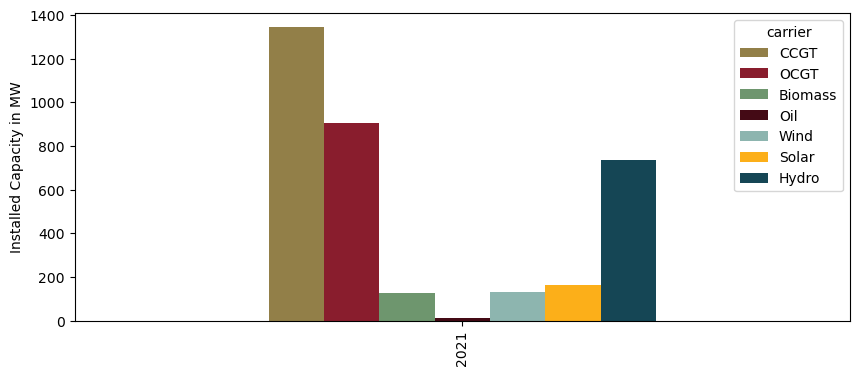

In [5]:
installed_capacity_21 = get_installed_capacity(single_net)
installed_capacity_21.index = [2021]
installed_capacity_21 = rename_columns(installed_capacity_21)
print(installed_capacity_21)
installed_capacity_21.plot(kind='bar',color=get_colors(installed_capacity_21.columns),figsize=(10, 4), legend=True)

plt.ylabel('Installed Capacity in MW')
plt.show()

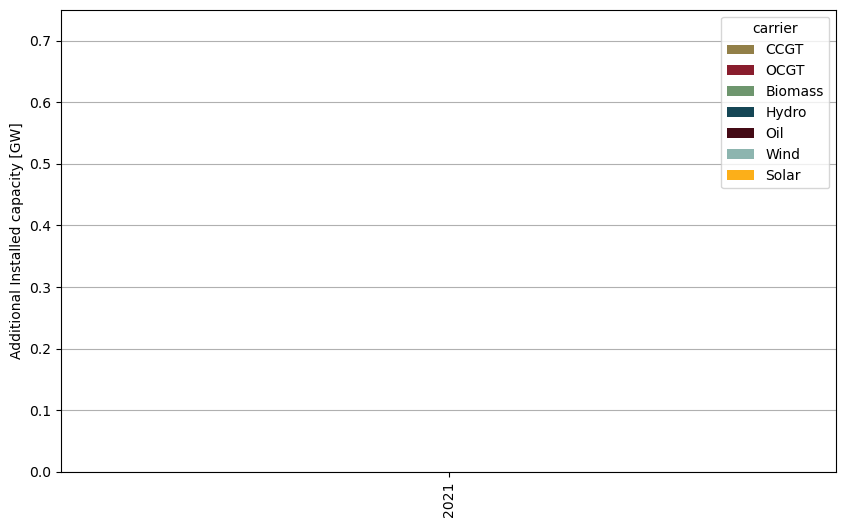

In [6]:
grouped_cap_change_B = get_new_installed(single_net)
grouped_cap_change_B = rename_columns(grouped_cap_change_B)
grouped_cap_change_B.plot.bar(stacked=True, figsize=(10, 6),color=get_colors(grouped_cap_change_B.columns))

plt.ylabel('Additional Installed capacity [GW]')
plt.xlabel('')
plt.xticks(range(len(grouped_cap_change_B.index)), grouped_cap_change_B.index, rotation=90)
plt.ylim(0.0,0.75)
plt.grid(axis = 'y',zorder = 0)

           OCGT   biomass      CCGT           oil     solar    onwind  \
0  3.195281e-07  0.105629  0.392364  8.506452e-09  0.029203  0.018527   

      hydro  
0  0.454277  


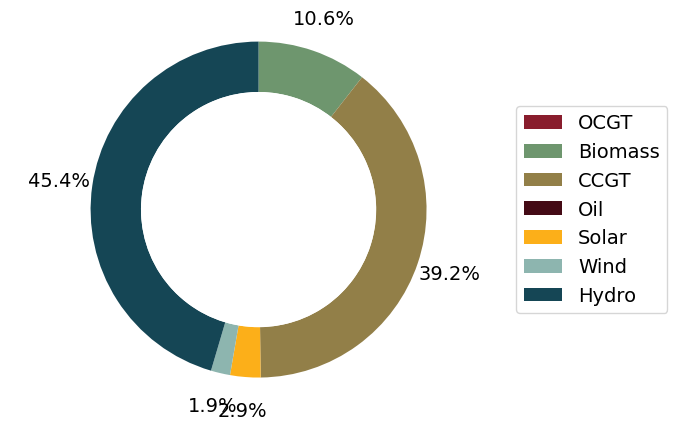

In [7]:
power_mix_df = get_power_mix(single_net)
print(power_mix_df)
plt.rcParams['font.size'] = 14
power_mix_df = rename_columns(power_mix_df)
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(power_mix_df.iloc[0].values, autopct=custom_autopct, colors=get_colors(power_mix_df.columns), startangle=90, counterclock=False, wedgeprops=dict(width=0.3), pctdistance=1.2)

# Hide the zero-value autotexts
for autotext in autotexts:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)

ax.axis('equal')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)


plt.legend(power_mix_df.columns, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

(<matplotlib.collections.PatchCollection at 0x1f9244580d0>,
 <matplotlib.collections.LineCollection at 0x1f9244c95a0>)

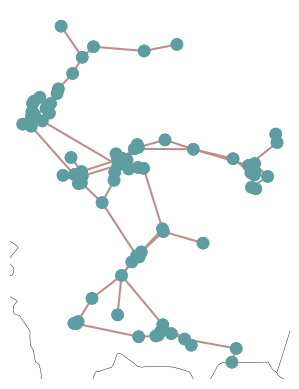

In [8]:
single_net.plot()

In [9]:
# Negative values because 
obj =single_net.objective
obj

60131248.707953274

In [10]:
# Investment cost of existing 
cons =single_net.objective_constant
cons

332470026.8386779

In [11]:
obj + cons

392601275.54663116

In [12]:
lines = single_net.lines[['s_nom_opt', 's_nom', 's_nom_min', 's_nom_max']] #Add lines in base network, adding components s_nom_min

In [13]:
(single_net.statistics.capex() + single_net.statistics.opex(aggregate_time="sum")).div(1e6).sum()


373.6326014464634

In [14]:
single_net.statistics()

Capacity Factor  Capital Expenditure  \
            carrier                                                    
Generator   Biomass                9.999999e-01         3.550812e+07   
            Combined-Cycle Gas     3.532387e-01         1.134479e+08   
            Oil                    8.571256e-07         4.588148e+05   
            Onshore Wind           1.704895e-01         1.436145e+07   
            Open-Cycle Gas         4.265532e-07         4.278318e+07   
            Run of River           9.999999e-01         9.854656e+07   
            Solar                  2.138968e-01         8.395318e+06   
            load                   1.804093e-14         0.000000e+00   
Line        AC                     9.203877e-02         1.175152e+08   
Link        battery charger        4.131616e-01         4.140200e+01   
            battery discharger     3.346609e-01         0.000000e+00   
Load        -                               NaN                  NaN   
StorageUnit Reservoir & Dam        5.000000e-01         0.000000e+00   
Store       Battery Storage        4.999980e-01         2.582156e+01   

                                Curtailment      Dispatch  Installed Capacity  \
            carrier                                                             
Generator   Biomass                0.000000  1.118827e+06        1.277200e+02   
            Combined-Cycle Gas     0.000000  4.155957e+06        1.343070e+03   
            Oil                    0.000000  9.010106e-02        1.200000e+01   
            Onshore Wind           0.154575  1.962445e+05        1.314000e+02   
            Open-Cycle Gas         0.000000  3.384469e+00        9.057600e+02   
            Run of River           0.000000  3.186187e+06        3.637200e+02   
            Solar                  0.258195  3.093169e+05        1.650800e+02   
            load                   0.000000  1.295916e-02        8.200000e+10   
Line        AC                          NaN -5.968693e+06        5.407116e+04   
Link        battery charger             NaN -3.891325e+00        0.000000e+00   
            battery discharger          NaN -3.502193e+00        0.000000e+00   
Load        -                           NaN -1.059208e+07                 NaN   
StorageUnit Reservoir & Dam        0.000000  1.625549e+06        3.711300e+02   
Store       Battery Storage             NaN  0.000000e+00        0.000000e+00   

                                Market Value  Operational Expenditure  \
            carrier                                                     
Generator   Biomass             1.387682e+01             2.402267e+06   
            Combined-Cycle Gas  1.387666e+01             5.766955e+07   
            Oil                 1.387665e+01             3.457979e+00   
            Onshore Wind        1.387680e+01             4.928480e+03   
            Open-Cycle Gas      1.387668e+01             5.312167e+01   
            Run of River        1.387664e+01             3.210532e+04   
            Solar               1.387661e+01             6.334313e+03   
            load                1.387660e+04             1.308857e+01   
Line        AC                  1.755962e-05                      NaN   
Link        battery charger     9.853920e-01             0.000000e+00   
            battery discharger  1.834621e+00             0.000000e+00   
Load        -                  -1.387666e+01                      NaN   
StorageUnit Reservoir & Dam     1.387664e+01             1.589992e+04   
Store       Battery Storage             -inf            -4.539154e-23   

                                Optimal Capacity       Revenue        Supply  \
            carrier                                                            
Generator   Biomass                 1.277200e+02  1.552576e+07  1.118827e+06   
            Combined-Cycle Gas      1.343070e+03  5.767079e+07  4.155957e+06   
            Oil                     1.200000e+01  1.250301e+00  9.010106e-02   
            O

In [15]:
round(single_net.loads_t.p_set.sum().sum()/1000000,8)

10.59208457

In [16]:
gens = single_net.generators

CCGT:  4155956.9800313897
OCGT:  3.384468580394189
Wind:  196244.52132062733
Solar:  309316.91219598125
Hydro:  4811736.28578421
Oil:  0.09010106364267165
Biomass:  1118827.1201297643
Total:  10592085.294031616


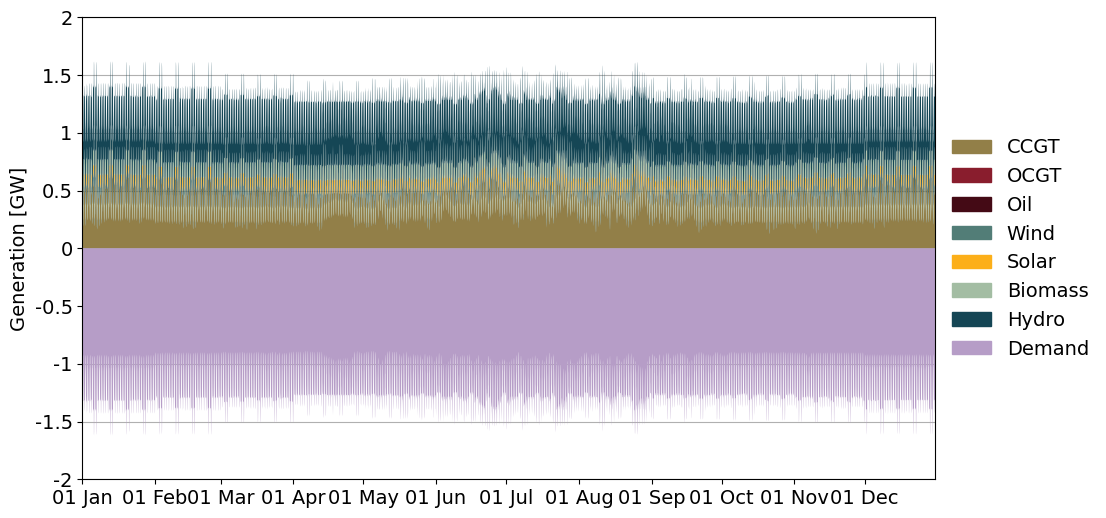

In [17]:
first_date = "2013-01-01"
second_date = "2013-12-31"
year = '2021'

CCGT = get_snapshot_generation(first_date, second_date, 'CCGT', single_net)
OCGT = get_snapshot_generation(first_date, second_date, 'OCGT',   single_net)
Oil = get_snapshot_generation(first_date, second_date, 'oil', single_net)
Wind = get_snapshot_generation(first_date, second_date, 'onwind', single_net)
Solar = get_snapshot_generation(first_date, second_date, 'solar', single_net)
Biomass = get_snapshot_generation( first_date, second_date, 'biomass', single_net)
Hydro = get_snapshot_generation(first_date, second_date, 'ror', single_net)
Hydro += get_snapshot_generation(first_date, second_date, 'hydro', single_net)
demand = get_snapshot_demand(single_net, first_date, second_date)   

print('CCGT: ', CCGT.sum())
print('OCGT: ', OCGT.sum())
print('Wind: ', Wind.sum())
print('Solar: ', Solar.sum())
print('Hydro: ', Hydro.sum())
print('Oil: ', Oil.sum())
print('Biomass: ', Biomass.sum())
print('Total: ', CCGT.sum() + OCGT.sum() + Wind.sum() + Solar.sum() + Hydro.sum() + Oil.sum() + Biomass.sum())

fig, ax=plt.subplots(figsize = (11,6))
A = plt.stackplot(CCGT.index,CCGT,OCGT,Oil, Wind, Solar, Biomass, Hydro, #,pbattery
                  colors=[beige1,green1,red1,teal3,yellow,green3,teal2], zorder = 2) #,   purple3
plt.stackplot(CCGT.index,demand, colors=[purple3], zorder = 2) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d %b')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('Generation [GW]')

start_date = pd.to_datetime(first_date)
end_date = pd.to_datetime(second_date)

ax.set_xlim(start_date, end_date)
ax.set_ylim(-2000, 2000)

CCGT_patch = mpatches.Patch(color=beige1, label ='CCGT')
OCGT_patch = mpatches.Patch(color=red1, label ='OCGT')
oil_patch = mpatches.Patch(color = brown, label = 'Oil')
wind_patch = mpatches.Patch(color=teal3, label ='Wind')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
biomass_patch = mpatches.Patch(color = green3, label = 'Biomass')
hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
load_patch = mpatches.Patch(color=purple3, label ='Demand')
handles=[CCGT_patch,OCGT_patch,oil_patch, wind_patch, solar_patch, biomass_patch, hydro_patch, load_patch]
ax.legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', zorder=0)